# Opposition Printer
## We're looking for opposition effects
### So I've created this code to find them. Hopefully.

This is going to be a somewhat complicated code that:
1) takes in a list of cubes
2) Goes through them one at a time
3) reads their information
4) Creates a plot trying to find the opposition effect in them, focusing on angles close to opposition.

The plot should have all eight windows, and have the points be colored by what type of terrain the surface is. This should be, as they say, fun.

Working T37 1574127168_1


C:\Users\deran\AppData\Local\Temp\ipykernel_37984\1302891948.py:230: RuntimeWarning: invalid value encountered in arccos
  azim = np.arccos(ratio)


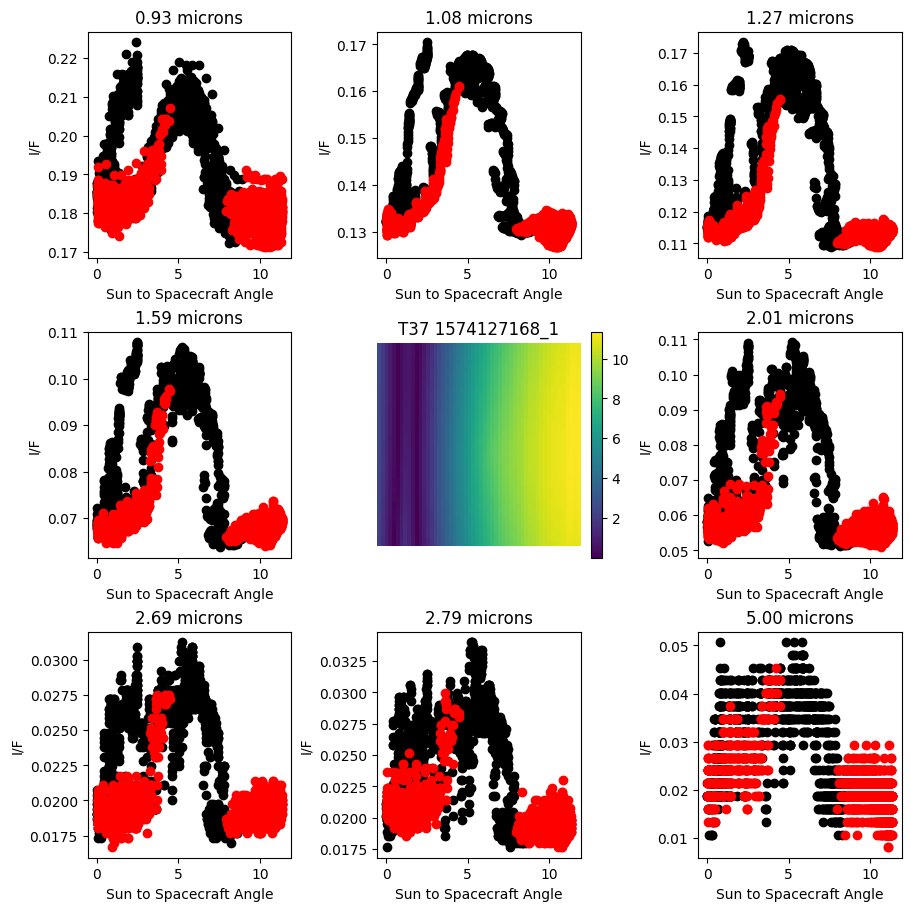

In [2]:
#CODE STRUCTURE.

#GRAB CUBE LIST
inputFile = "oppositionGlobalList.csv" #Shoudl be a "...CubeList" file made by DatabaseSearcher. Includes flyby and cube number, nothing else. 
inputFile = "..\\DatabaseSearcher\\" + inputFile

#Imports
import csv
import math
import numpy as np
import scipy.misc
import matplotlib.pyplot as plt
from scipy import ndimage

#First, read in the data into a matrix. 
cubeList = []
with open(inputFile) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        triplet = ["A","A"]
        triplet[0] = row[0]
        triplet[1] = row[1]
        cubeList.append(triplet)
        line_count += 1

CLRMask = np.load("CLRMaskArray.npy")
#Need to make sure this file exists, user. 
#Colored Mask has all types of terrain marked, as well as no-go zones. 

CLRMaskDist = np.load("CLRMaskArrayDist.npy") #Holds the actual measures for distance at each point. 
#Now, for every item in cubeList, we find the file it points to and read it in. 
#Then we examine those files for *something*. Whatever it is. 
#Any pixel that matches that something, we keep. 

#FOR EACH LINE
startAgain = False

for item in cubeList:
    #For checking if we're restarting at the right place
    if (item[0] == "T37" and item[1] == "1574127168_1"): startAgain = True
    else: startAgain = False 
    if (startAgain == False): continue
    
    #READ IN CUBE DATA
    
    #This code is copy adapted from the VIMS Cube Visualisation Interface Notebook. 
    #It is complicated.
    filepath = "C:\\Users\\deran\\Desktop\\CubeCSVDatabase\\" + item[0] + "\\CM_" + item[1] + ".cub.csv"

    #Now we extract the axes file as well...
    cubeAxesfp = filepath.removesuffix(".csv") + ".axes.csv"
    #and the geo files. 
    cubeGeofpIR = filepath.removesuffix(".cub.csv") + "_ir_geo.cub.csv"
    cubeGeofpIRaxes = filepath.removesuffix(".cub.csv") + "_ir_geo.cub.axes.csv"

    #Skeleton code nabbed from https://realpython.com/python-csv/
    
    #Step 1: use the axes to determine the size of what we're dealing with.
    xAxisCube = []
    yAxisCube = []
    zAxisCube = []
    
    xAxisGeoIR = []
    yAxisGeoIR = []
    zAxisGeoIR = []

    err=0

    try:
        with open(cubeAxesfp) as csv_file: #remember to tab.
                csv_reader = csv.reader(csv_file, delimiter=',')
                line_count = 0
                for row in csv_reader:
                    i = 0
                    L = len(row)
                    while (i < L-1):
                        if (line_count == 0):
                            xAxisCube.append(row[i])
                        elif (line_count == 1):
                            yAxisCube.append(row[i])
                        elif (line_count == 2):
                            zAxisCube.append(row[i])
                        i = i+1
                    line_count += 1
    except:
        print("No Cube Axes", item[0], item[1])
        err = 1 #whoops.        
    try:
        with open(cubeGeofpIRaxes) as csv_file: #remember to tab.
                csv_reader = csv.reader(csv_file, delimiter=',')
                line_count = 0
                for row in csv_reader:
                    i = 0
                    L = len(row)
                    while (i < L-1):
                        if (line_count == 0):
                            xAxisGeoIR.append(row[i])
                        elif (line_count == 1):
                            yAxisGeoIR.append(row[i])
                        elif (line_count == 2):
                            zAxisGeoIR.append(row[i])
                        i = i+1
                    line_count += 1
    except:
        print("No Geo Axes", item[0], item[1])
        err = 1 #whoops.
        
    #We now have an x, y, and z axis. x and y axes are just ordinal, but the z axis contains wavelength in microns.
    #The lengths of these arrays tell us how to extract the data.
    
    cubeData = [[[0 for x in range(len(zAxisCube))] for x in range(len(yAxisCube))] for x in range(len(xAxisCube))]
    geoIRData = [[[0 for x in range(len(zAxisGeoIR))] for x in range(len(yAxisGeoIR))] for x in range(len(xAxisGeoIR))]
    
    #The above holds the data of the cube itself. 
    try:
        with open(filepath) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            line_count = 0
            i, j, k = 0, 0, 0
            for row in csv_reader:
                while (i < len(xAxisCube)):
                    cubeData[i][j][k] = float(row[i])
                    if (math.isnan(cubeData[i][j][k])):
                        cubeData[i][j][k] = 0 #We set nans to zero to allow plotting to take place, careful!
                    elif (cubeData[i][j][k] < 0):
                        cubeData[i][j][k] = 0 #Negative values are nonsense.
                    elif (cubeData[i][j][k] > 1):
                        cubeData[i][j][k] = 1 #Make saturation obvious? Keep it from overloading. 
                    i = i + 1
                i = 0
                j = j + 1
                if (j >= len(yAxisCube)):
                    j = 0
                    k = k + 1
                line_count += 1
    except:
        print("No Cube File (how?)", item[0], item[1])
        err = 1 #whoops.
    try:
        with open(cubeGeofpIR) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            line_count = 0
            i, j, k = 0, 0, 0
            for row in csv_reader:
                while (i < len(xAxisGeoIR)):
                    geoIRData[i][j][k] = float(row[i])
                    if (math.isnan(geoIRData[i][j][k])):
                        geoIRData[i][j][k] = 0 #We set nans to zero to allow plotting to take place, careful!
                    elif (geoIRData[i][j][k] < -1000):
                        geoIRData[i][j][k] = 0 #The default value is an extremely negative number. Scrub it.
                    i = i + 1
                i = 0
                j = j + 1
                if (j >= len(yAxisGeoIR)):
                    j = 0
                    k = k + 1
                line_count += 1
    except:
        print("No Geo File", item[0], item[1])
        err = 1 #Whoops.
    #The data is now read in.

    #BOOKKEEPING: declare where the windows are. 
    windowum = [0.933078, 1.08183, 1.27813, 1.59018, 2.01781, 2.69620, 2.79889, 5.00576]
    windowInd = [80, 108, 120, 139, 165, 206, 212, 344]
    windowIndAlt = [3,12,24,43,69,110,116,248]
    if (len(zAxisCube) <= 256):
        windowInd = windowIndAlt #Sometimes the cubes have different indeces. It's weird,  yeah, but this is how we check for that. 

    print("Working", item[0], item[1])
        
    #Now we can do stuff with the data. In this case, we need to examine every pixel and print out the "viable" ones to a file. 
    #EXTRACT RELEVANT INFORMATION


    masterDataArray = [[[] for x in range(9)] for x in range(8)] #arranged by masterDataArray[Terrain][Wavelength] where 0 wavelength is just the x position (opposition).  
    OPPOSITION = [[0 for x in range(len(yAxisCube))] for x in range(len(xAxisCube))]
    
    if (err == 0):
        x,y = 0,0 
        while (x < len(xAxisCube)):
            y = 0
            while (y < len(yAxisCube)):
                #Inintial checks of pixel locaiton and resolution. Only continue if tests passed. 
                #Now at this point we perform the mask test, but we have to start gatehring some values before we can do that. 
                lat = geoIRData[x][y][0]
                lon = geoIRData[x][y][1]
                #Round to the nearest whole number.
                lat = int(np.rint(lat))
                lon = 360 - int(np.rint(lon)) #Have to flip our longitude. 
                #not because it's wrong, but because the INDEX of the MASK is FLIPPED.
                if (lon >= 360): lon = 0
                if (lat <= -89): lat = -89
                #Now these are our latlon coordinates. We can use them to find the mask we need.
                temp = np.transpose(cubeData)

                #Color Determination: what type of surface are we looking at? Label it!
                color = "Null" #No classification. Would be what a bad pixel recieved
                #But it should not be possible to get one at this point.
                if (CLRMask[90-lat][lon][0] == 0):
                    if (CLRMask[90-lat][lon][1] == 0):
                        if (CLRMask[90-lat][lon][2] == 0):
                            color = "Null" #Black for no-go zone...
                        else:
                            color = "Lake" #Blue for Craters
                    else:
                        if (CLRMask[90-lat][lon][2] == 0):
                            color = "Xanadu" #Green for Xanadu
                        else:
                            color = "Crater" #Cyan for Craters
                else:
                    if (CLRMask[90-lat][lon][1] == 0):
                        if (CLRMask[90-lat][lon][2] == 0):
                            color = "Dunes" #Red for dunes
                        else:
                            color = "Labyrinth" #Magenta for Labyrinth
                    else:
                        if (CLRMask[90-lat][lon][2] == 0):
                            color = "Hummocky" #Yellow for "hummocky" 
                        else:
                            color = "Plains" #White for Plains
                #Fortunately we read lon in directly so the fact that we flipped it isn't an issue.
                inci = geoIRData[x][y][5]
                emis = geoIRData[x][y][6]
                azim = 0.
                #Azimuth formula from Jason Barnes' phasecurve.c++
                p = geoIRData[x][y][4] #used to calculate azimuth.
                ratio = -(np.cos(np.radians(p)) - np.cos(np.radians(inci))* np.cos(np.radians(emis)))/(np.sin(np.radians(inci))*np.sin(np.radians(emis)))
                azim = np.arccos(ratio)
                #Of course, this might be nan-ing. All the nans need their own values.
                if((math.isnan(azim) == True) and (ratio>0.)):
                    azim = 0.
                elif((math.isnan(azim) == True) and (ratio<0.)):
                    azim = 0.
                elif((inci==0) and (emis==0)):
                    azim = 0.
                elif(math.isnan(azim) == True):
                    print("Well you broke it, great. (Azimuth is nan, but could not be set to anything else.)")
                if (inci < 0):
                    inci = 0
                elif (inci > 100):
                    inci = 100
                if (emis < 0):
                    emis = 0
                elif (emis > 90):
                    emis = 90
                if (azim < 0):
                    azim = 0
                if (azim > 180):
                    azim = 180
                #Now we need the window wavelengths, which means we need to *read* the data itself.
                wavs = [np.transpose(temp[windowInd[0]])[x][y], np.transpose(temp[windowInd[1]])[x][y], np.transpose(temp[windowInd[2]])[x][y], np.transpose(temp[windowInd[3]])[x][y],
                    np.transpose(temp[windowInd[4]])[x][y], np.transpose(temp[windowInd[5]])[x][y], np.transpose(temp[windowInd[6]])[x][y], np.transpose(temp[windowInd[7]])[x][y]]
                opposition = math.acos(math.cos(inci*(np.pi/180))*math.cos(emis*(np.pi/180))+math.sin(inci*(np.pi/180))*math.sin(emis*(np.pi/180))*math.cos(azim*(np.pi/180)))*(180/np.pi)
                OPPOSITION[x][y] = math.acos(math.cos(inci*(np.pi/180))*math.cos(emis*(np.pi/180))+math.sin(inci*(np.pi/180))*math.sin(emis*(np.pi/180))*math.cos(azim*(np.pi/180)))*(180/np.pi)
                

            
                #Now we can sort the individual pixel to where it goes in the masterDataArray
                if (color == "Null"):
                    wav = 1
                    masterDataArray[0][0].append(opposition)
                    while (wav <= 8):
                        masterDataArray[0][wav].append(wavs[wav-1])
                        wav=wav+1
                elif (color == "Lake"):
                    wav = 1
                    masterDataArray[1][0].append(opposition)
                    while (wav <= 8):
                        masterDataArray[1][wav].append(wavs[wav-1])
                        wav=wav+1
                elif (color == "Xanadu"):
                    wav = 1
                    masterDataArray[2][0].append(opposition)
                    while (wav <= 8):
                        masterDataArray[2][wav].append(wavs[wav-1])
                        wav=wav+1
                elif (color == "Crater"):
                    wav = 1
                    masterDataArray[3][0].append(opposition)
                    while (wav <= 8):
                        masterDataArray[3][wav].append(wavs[wav-1])
                        wav=wav+1
                elif (color == "Dunes"):
                    wav = 1
                    masterDataArray[4][0].append(opposition)
                    while (wav <= 8):
                        masterDataArray[4][wav].append(wavs[wav-1])
                        wav=wav+1
                elif (color == "Labyrinth"):
                    wav = 1
                    masterDataArray[5][0].append(opposition)
                    while (wav <= 8):
                        masterDataArray[5][wav].append(wavs[wav-1])
                        wav=wav+1
                elif (color == "Hummocky"):
                    wav = 1
                    masterDataArray[6][0].append(opposition)
                    while (wav <= 8):
                        masterDataArray[6][wav].append(wavs[wav-1])
                        wav=wav+1
                elif (color == "Plains"):
                    wav = 1
                    masterDataArray[7][0].append(opposition)
                    while (wav <= 8):
                        masterDataArray[7][wav].append(wavs[wav-1])
                        wav=wav+1
                        
                y=y+1
            x=x+1 
        
        #PLOT INFORMATION
        #Just to show the cube we are reading in.
        fig, axs = plt.subplots(3,3, figsize = (9,9), layout = "constrained") 
        
        temp = np.transpose(cubeData)
        
        #COLOR
        #One of our colors is an average in titancolor2, so we need to grab it:
        ofs = 96 #offset for when we don't have a "full" cube. It should always be 96.
        
        if (len(zAxisCube) > 256):
            ave = (temp[336]+temp[337]+temp[338]+temp[339]+temp[340]+temp[341]
                  +temp[342]+temp[343]+temp[344]+temp[345]+temp[346]+temp[347]
                  +temp[348]+temp[349]+temp[350]+temp[351])/16.
            mod = 1.
        
            # set R, G, and B
            R = ave/(mod*1.12/16.) #Average dealing shenanigans.
            G = temp[165]/(mod*0.22)
            B = (temp[120]-0.03)/(mod*0.37)
        else:
            ave = (temp[336-ofs]+temp[337-ofs]+temp[338-ofs]+temp[339-ofs]+temp[340-ofs]+temp[341-ofs]
                  +temp[342-ofs]+temp[343-ofs]+temp[344-ofs]+temp[345-ofs]+temp[346-ofs]+temp[347-ofs]
                  +temp[348-ofs]+temp[349-ofs]+temp[350-ofs]+temp[351-ofs])/16.
            mod = 1.
        
            # set R, G, and B
            R = ave/(mod*1.12/16.) #Average dealing shenanigans.
            G = temp[165-ofs]/(mod*0.22)
            B = (temp[120-ofs]-0.03)/(mod*0.37)
        #B's value can introduce negatives, remove them.
        i,j = 0,0
        for x in B:
            j=0
            for y in x:
                if (y < 0):
                    B[i][j] = 0
                j = j+1
            i = i+1
        
        # Now we need to combine them in the correct form: xyc, that is, x, y, then color value. 
        colorData = [R,G,B] # arranged in cyx. I thought RGB needed to be transposed but evidentialy not. Hmm.
        colorData = np.transpose(colorData) #arranged in xyc
        
        image = axs[1,1].imshow(ndimage.rotate(colorData,90), origin="lower") 
        
        axs[1,1].set(title="bestcolor (~5.00, 2.01, 1.27)")

        colors = ["black", "blue", "lime", "cyan", "red", "pink", "orange", "green"]

        terr=0
        while (terr <= 7):    
            axs[0][0].scatter(masterDataArray[terr][0],masterDataArray[terr][1], color = colors[terr]) 
            axs[0][1].scatter(masterDataArray[terr][0],masterDataArray[terr][2], color = colors[terr]) 
            axs[0][2].scatter(masterDataArray[terr][0],masterDataArray[terr][3], color = colors[terr]) 
            axs[1][0].scatter(masterDataArray[terr][0],masterDataArray[terr][4], color = colors[terr]) 
            axs[1][2].scatter(masterDataArray[terr][0],masterDataArray[terr][5], color = colors[terr])
            axs[2][0].scatter(masterDataArray[terr][0],masterDataArray[terr][6], color = colors[terr])
            axs[2][1].scatter(masterDataArray[terr][0],masterDataArray[terr][7], color = colors[terr])
            axs[2][2].scatter(masterDataArray[terr][0],masterDataArray[terr][8], color = colors[terr])
            terr=terr+1
        
        axs[1,1].axis('off')
        
        #image = axs[1,1].imshow(ndimage.rotate(colorData,90),origin="lower") 
        #The rotation is undone here using rotate(). 

        #centerc = axs[1,1].imshow(OPPOSITION, cmap="viridis")
        #fig.colorbar(centerc, ax=axs[1][1])
        
        axs[0][0].set(title = "0.93 microns")
        axs[0][1].set(title = "1.08 microns")
        axs[0][2].set(title = "1.27 microns")
        axs[1][0].set(title = "1.59 microns")
        axs[1][2].set(title = "2.01 microns")
        axs[2][0].set(title = "2.69 microns")
        axs[2][1].set(title = "2.79 microns")
        axs[2][2].set(title = "5.00 microns")
        
        axs[0][0].set_xlabel("Sun to Spacecraft Angle")
        axs[0][1].set_xlabel("Sun to Spacecraft Angle")
        axs[0][2].set_xlabel("Sun to Spacecraft Angle")
        axs[1][0].set_xlabel("Sun to Spacecraft Angle")
        axs[1][2].set_xlabel("Sun to Spacecraft Angle")
        axs[2][0].set_xlabel("Sun to Spacecraft Angle")
        axs[2][1].set_xlabel("Sun to Spacecraft Angle")
        axs[2][2].set_xlabel("Sun to Spacecraft Angle")
        
        axs[0][0].set_ylabel("I/F")
        axs[0][1].set_ylabel("I/F")
        axs[0][2].set_ylabel("I/F")
        axs[1][0].set_ylabel("I/F")
        axs[1][2].set_ylabel("I/F")
        axs[2][0].set_ylabel("I/F")
        axs[2][1].set_ylabel("I/F")
        axs[2][2].set_ylabel("I/F")
        
        axs[1,1].set(title="T37 1574127168_1")

        #SAVE INFORMATION AS IMAGE FILE
        plt.savefig("OppositionSearch_"+ str(item[0]) + "_" + str(item[1]) +".pdf", format='pdf', bbox_inches='tight')
 